In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np

import logging
import pickle
from tqdm import tqdm


import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
x = 50
plt.rcParams['figure.figsize'] = [640/x, 480 /x]




In [3]:
img_out_path = 'image_out/'

if os.path.exists(img_out_path) is False:
    os.mkdir(img_out_path)

In [4]:
video_target_path = r'D:\Github\retinal_flow_toolkit\flow_out\dash_cam\dash_cam_nvidia2_hsv_overlay.mp4'
video = cv2.VideoCapture(video_target_path)

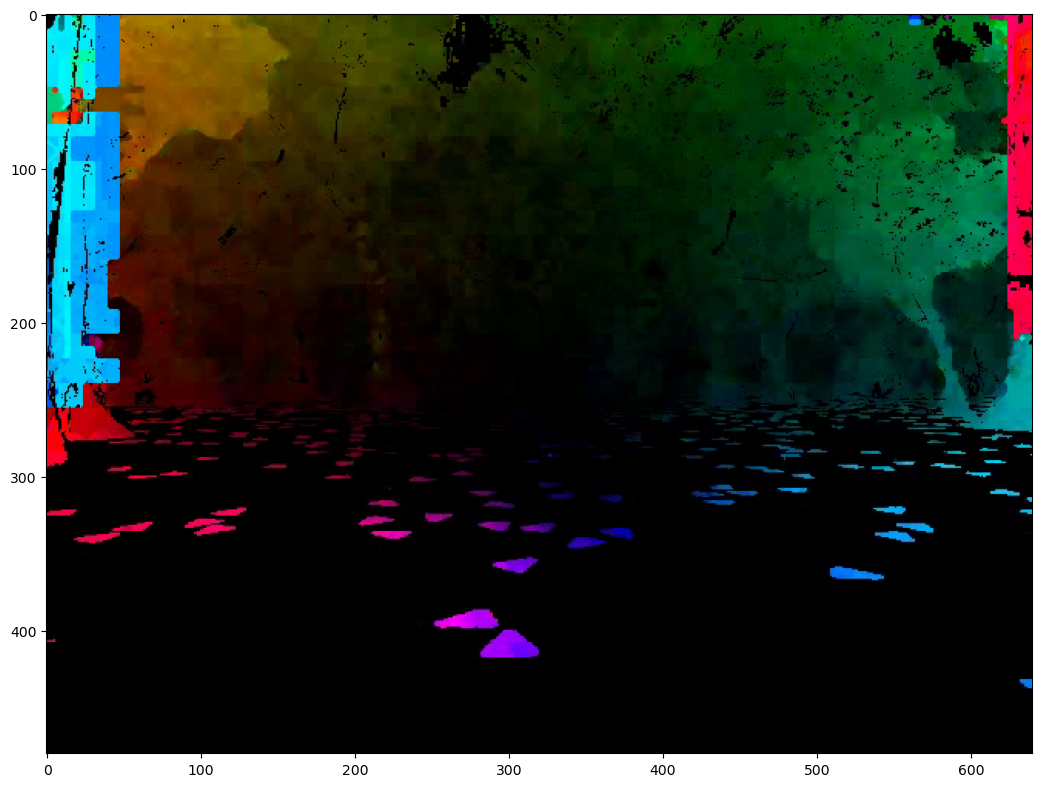

In [33]:
success = 1

f = 40
#14627 # rigth turn
video.set(cv2.CAP_PROP_POS_FRAMES, f)
success, hsv_image = video.read()

plt.imshow(cv2.cvtColor(hsv_image, cv2.COLOR_BGR2RGB))

### Polar histogram of hue counts 

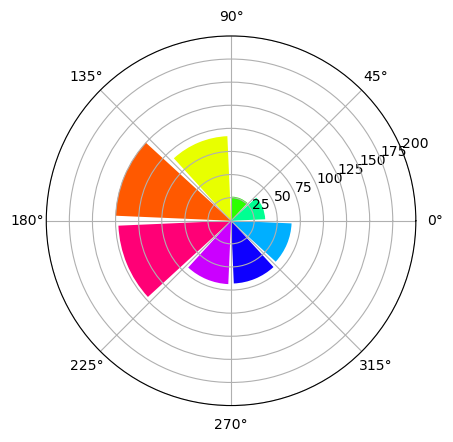

In [34]:
from matplotlib import cm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from collections import deque

bin_rad_hist = deque(maxlen=30)
width = 640
height = 480

dpi = 100
fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), subplot_kw=dict(projection='polar'))
canvas = FigureCanvas(fig)
ax.margins(0)

ax.set_ylim([0, 200])

hist_params = (4 *2, 0, 360)
bins = np.linspace(hist_params[1], hist_params[2], hist_params[0] + 1)
bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]

cvals = np.array(bin_centers)/359+0.5
cvals[cvals > 1] = cvals[cvals > 1] - 1
hsv_map = cm.get_cmap('hsv').reversed()
bar_colors = hsv_map(cvals)

h = hsv_image[..., 0]
v = hsv_image[..., 2]

mag_flat = v.flatten()[v.flatten() > .1]
hue_flat = h.flatten()[v.flatten() > .1]

hue_flat = hue_flat * 2.0

bin_rad = []
for b_idx in range(1, len(bins)):
    idx = np.where(np.logical_and(hue_flat >= bins[b_idx - 1], hue_flat <= bins[b_idx]))
    bin_rad.append(np.mean(mag_flat[idx]))

bin_rad = np.nan_to_num(bin_rad)
# bin_rad_hist.appendleft(bin_rad)

ax.bar(np.deg2rad(bin_centers), bin_rad, width=2 * (np.pi / (len(bins))), color=bar_colors);

# plt.show
# canvas.draw()  # draw the canvas, cache the renderer
# image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# image_from_plot = image_from_plot.reshape(fig.canvas.get_width_height()[::-1] + (3,))



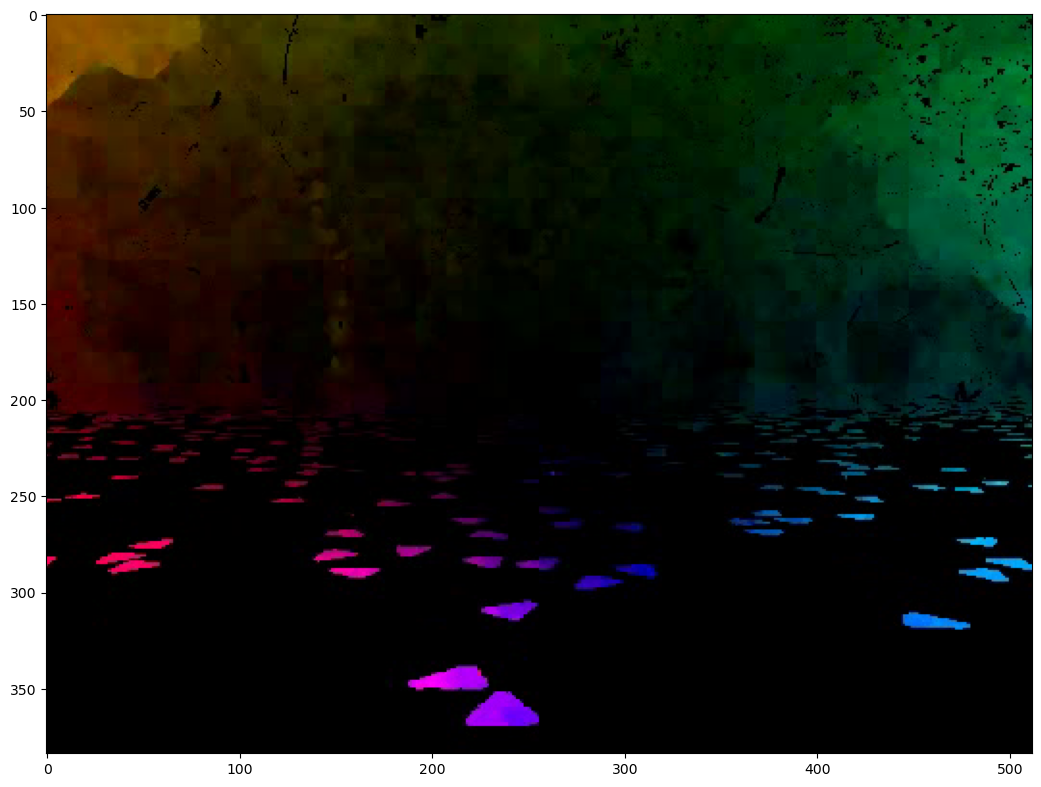

In [35]:

h = np.shape(hsv_image)[0]
w = np.shape(hsv_image)[1]

# width of analysis window in proportions of image width/height
win_size = 0.8

b = int(h/2 + (win_size*h)/2)
t = int(h/2 - (win_size*h)/2)
l = int(w/2 - (win_size*w)/2)
r = int(w/2 + (win_size*w)/2)

sm_image = hsv_image[t:b,l:r,:]
plt.imshow(cv2.cvtColor(sm_image, cv2.COLOR_BGR2RGB))

In [36]:
h = sm_image[..., 0]
v = sm_image[..., 2]

mag_flat = v.flatten()[v.flatten() > .1]
hue_flat = h.flatten()[v.flatten() > .1]

uidx = int(len(np.unique(mag_flat))/2)
val = np.unique(mag_flat)[uidx]

idx = np.where(mag_flat == uidx)[0][0]
print( f'Value - {mag_flat[idx]} Hue - {hue_flat[idx]}')

Value - 127 Hue - 0


https://notebook.community/joverbee/electromagnetism_course/vector_example

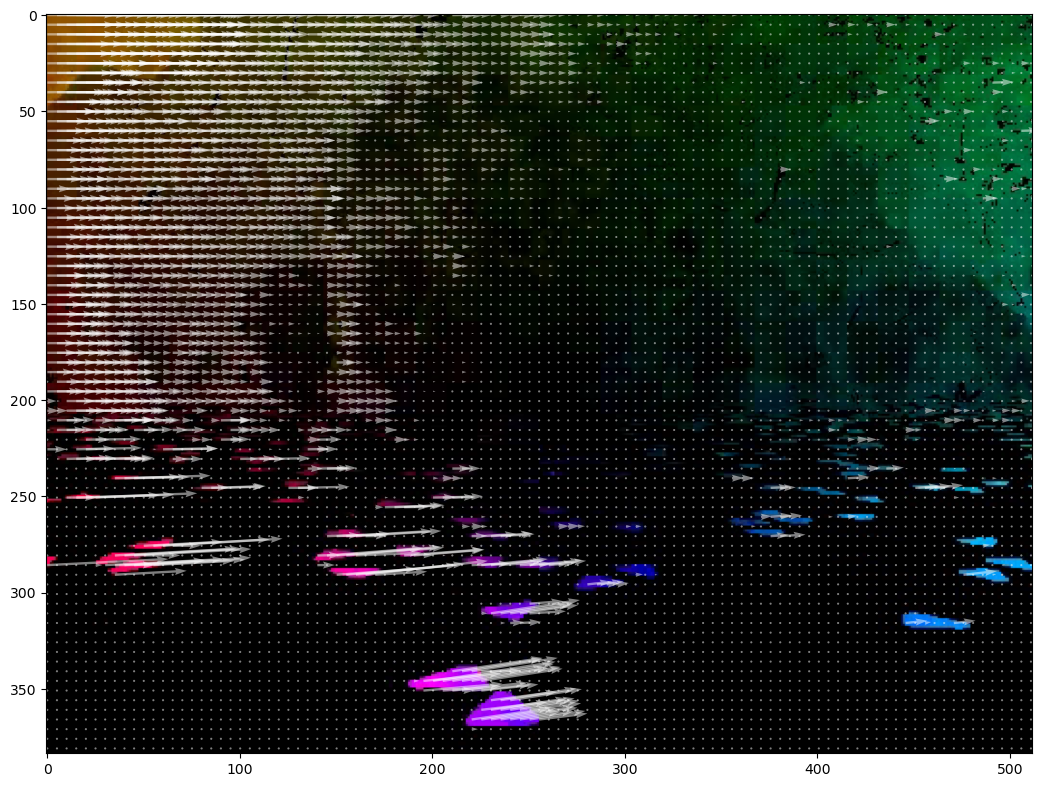

In [47]:
# rescale from 0-255 to 0-upper mag threshold (15)
mag = 15 * (sm_image[..., 2] / 255.0)

h = sm_image[..., 0]
# h = (angle * 180) / np.pi / 2
angle_degs = (sm_image[..., 0] * np.pi * 2.0) /180.0

xmax=np.shape(sm_image)[1]
xpoints = int(np.shape(sm_image)[1])
x=np.linspace(0,np.shape(sm_image)[1],xmax)

ymax=np.shape(sm_image)[0]
ypoints = int(np.shape(sm_image)[0])
y=np.linspace(0,np.shape(sm_image)[0],ymax)

x2d,y2d=np.meshgrid(x,y,indexing='xy')

u = mag * np.cos(np.deg2rad(angle_degs)) 
v = mag * np.sin(np.deg2rad(angle_degs)) 

skippts=5
skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy

plt.imshow(cv2.cvtColor(sm_image, cv2.COLOR_BGR2RGB))
plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white',alpha=0.5)

plt.show()

In [38]:
np.shape(x2d)

(384, 512)

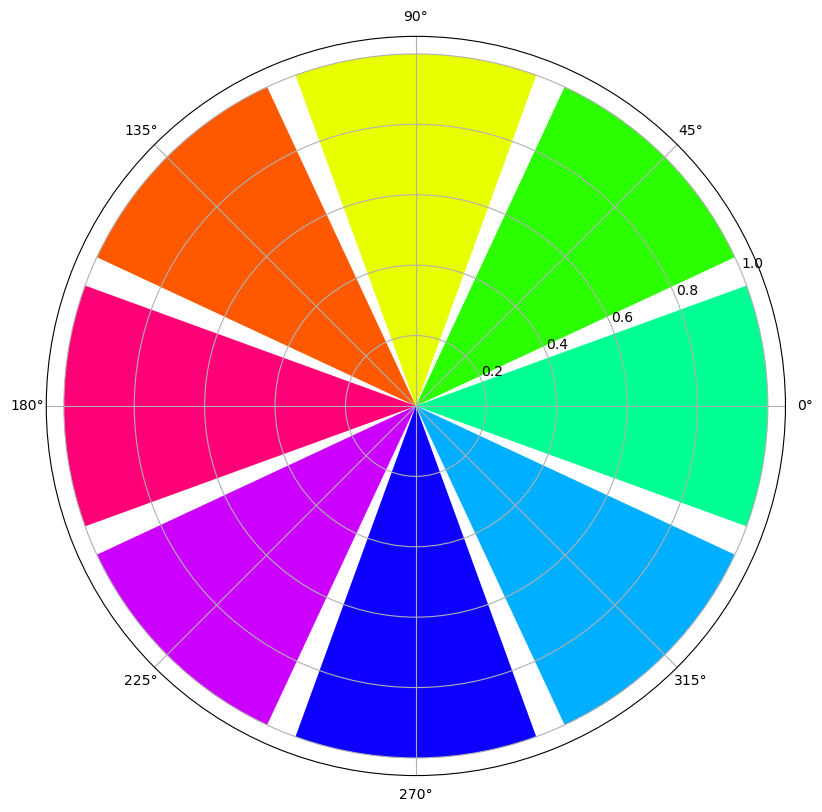

In [39]:
from matplotlib import cm
hsv_map = cm.get_cmap('hsv').reversed()

bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
cvals = np.array(bin_centers)/359+0.5
cvals[cvals>1] = cvals[cvals>1]-1
colors = hsv_map(cvals)

counts = np.ones(len(bins)-1)
ax = plt.subplot(111, polar=True)

bars = ax.bar(np.deg2rad(bins[:-1]), counts, width=2*(np.pi / (len(bins))), color=colors)

# ax.set_ylim(.002)
plt.show()

In [ ]:
# def divergence_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dx = np.gradient(Fx, axis=0)
#     dFy_dy = np.gradient(Fy, axis=1)
#     return dFx_dx + dFy_dy

# def curl_npgrad(flow):
#     flow = np.swapaxes(flow, 0, 1)
#     Fx, Fy = flow[:, :, 0], flow[:, :, 1]
#     dFx_dy = np.gradient(Fx, axis=1)
#     dFy_dx = np.gradient(Fy, axis=0)
#     curl = dFy_dx - dFx_dy
#     return curl